<a href="https://colab.research.google.com/github/RaccoonSec/Predicting-Link-Quality-on-Time-Series/blob/master/Predicting-Link-Quality-on-Time-Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime, time
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from google.colab import drive

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!unzip /content/160115.zip

In [0]:
files = glob("/content/160115/*.tsv")
dataset = pd.concat([pd.read_csv(f, sep="\t", skiprows=1) for f in files], 
           ignore_index=True).rename(columns={'LQ': 'y'})

#dt_from = pd.to_datetime("2016-01-15 00:00:00.000000")
#dt_to = pd.to_datetime("2016-01-15 23:59:59.999999")
#dataset.insert(0, "ds", pd.date_range(dt_from, dt_to, periods=len(dataset)))

### усредняем данные до минуты (resampling -> 1 min. frequency)
#new_data = dataset.set_index("ds").resample("2T").mean().reset_index()
#del new_data['NLQ']

new_data_norm = (dataset['y'] - dataset['y'].min()) / (dataset['y'].max() - dataset['y'].min())

#new_data_norm.head()

df = pd.DataFrame(new_data_norm)
dt_from = pd.to_datetime("2016-01-16 00:00:00.000000")
dt_to = pd.to_datetime("2016-01-16 23:59:59.999999")
df.insert(0, "ds", pd.date_range(dt_from, dt_to, periods=len(df)))

new_data = df.set_index("ds").resample("2T").mean().reset_index()


In [0]:
def tsplot(y, lags=None, figsize=(20, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
 
        print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return

Dickey-Fuller test: p=0.000001


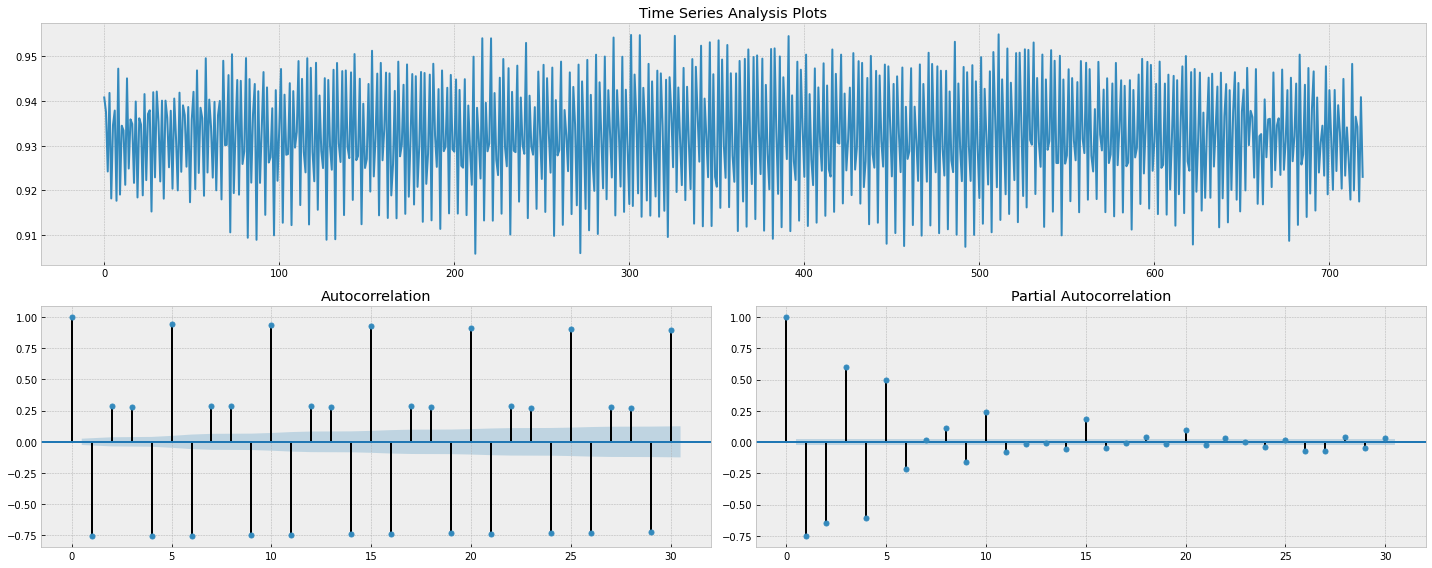

In [42]:
tsplot(new_data.y, lags=30)

Dickey-Fuller test: p=0.000001


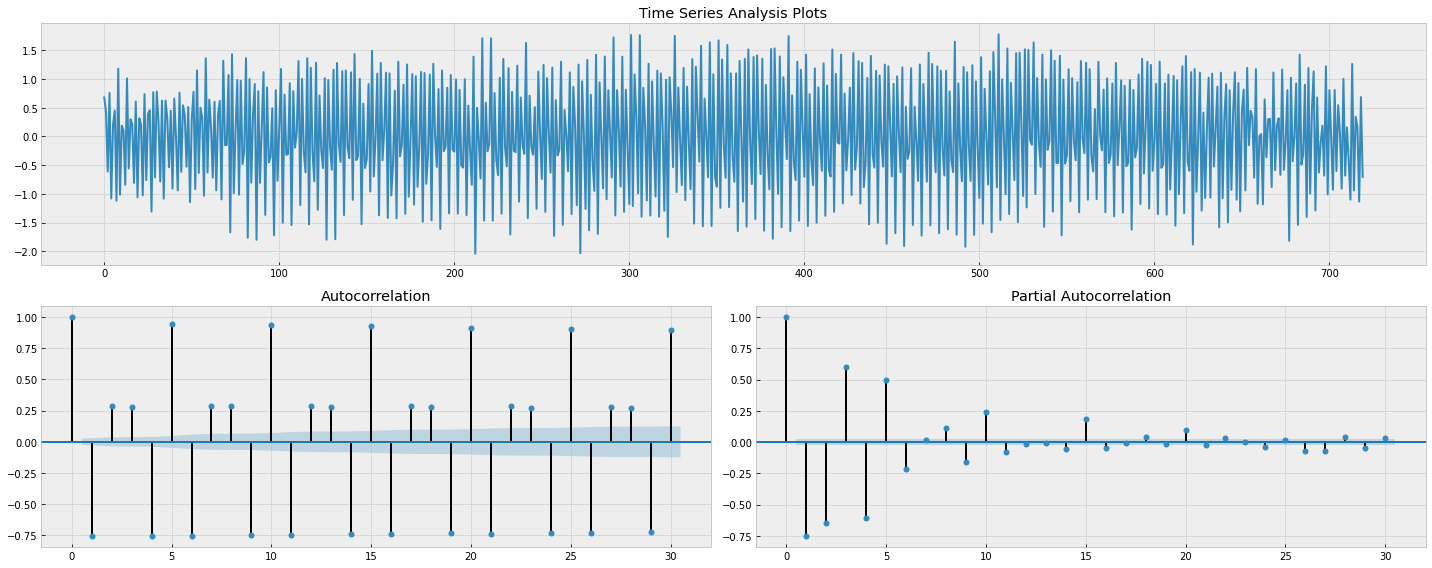

In [43]:
'''def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = new_data.copy()
data['y_box'], lmbda = scs.boxcox(data.y) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.y_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)'''

def standart_deviation_norm(wine_data, head_value):
  mue = sum(wine_data[head_value]) / wine_data.shape[0]
  var = sum([math.pow(x-mue,2) for x in wine_data[head_value]])
  sigma = math.sqrt(var / (wine_data.shape[0] - 1))
  return [(x - mue) / sigma for x in wine_data[head_value]]


standart_deviation_norm(new_data, 'y')

data = new_data.copy()

data['y_sdn'] = standart_deviation_norm(new_data, 'y')
tsplot(data.y_sdn, lags=30)

In [44]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [45]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.y_sdn, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 7min 19s, sys: 5min 3s, total: 12min 23s
Wall time: 6min 21s


In [46]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
59  (4, 2, 1, 1)  344.288389
57  (4, 2, 0, 1)  345.815156
49  (4, 0, 0, 1)  399.950972
51  (4, 0, 1, 1)  400.247938
53  (4, 1, 0, 1)  400.705368


In [47]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              y_sdn   No. Observations:                  720
Model:             SARIMAX(4, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -163.144
Date:                            Sun, 17 May 2020   AIC                            344.288
Time:                                    08:50:59   BIC                            385.338
Sample:                                         0   HQIC                           360.149
                                            - 720                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7707      0.044    -17.368      0.000      -0.858      -0.684
ar.L2         -0.1718      0.054   

Проверяю остатки

Критерий Стьюдента: p=0.884148
Критерий Дики-Фуллера: p=0.000000


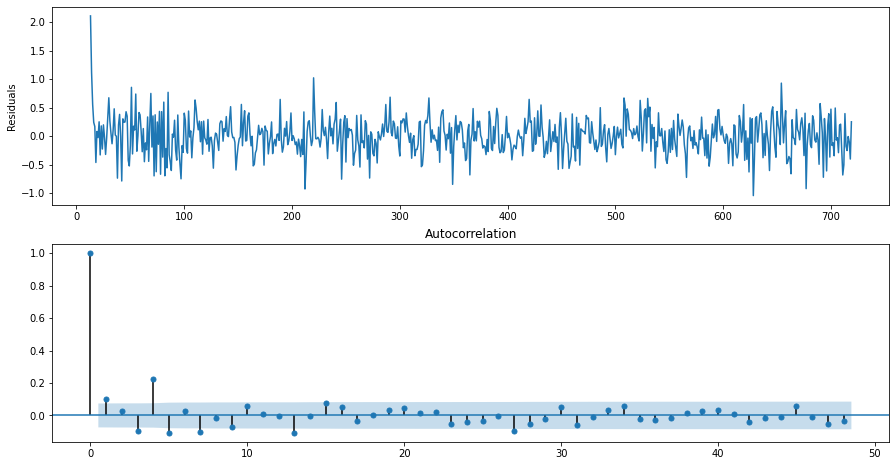

In [48]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])



График модели

0      0.000000
1      0.680134
2      0.427606
3     -0.610498
4      0.758745
         ...   
715    0.598819
716    0.174804
717   -1.032286
718    1.088443
719   -0.954905
Name: model, Length: 720, dtype: float64


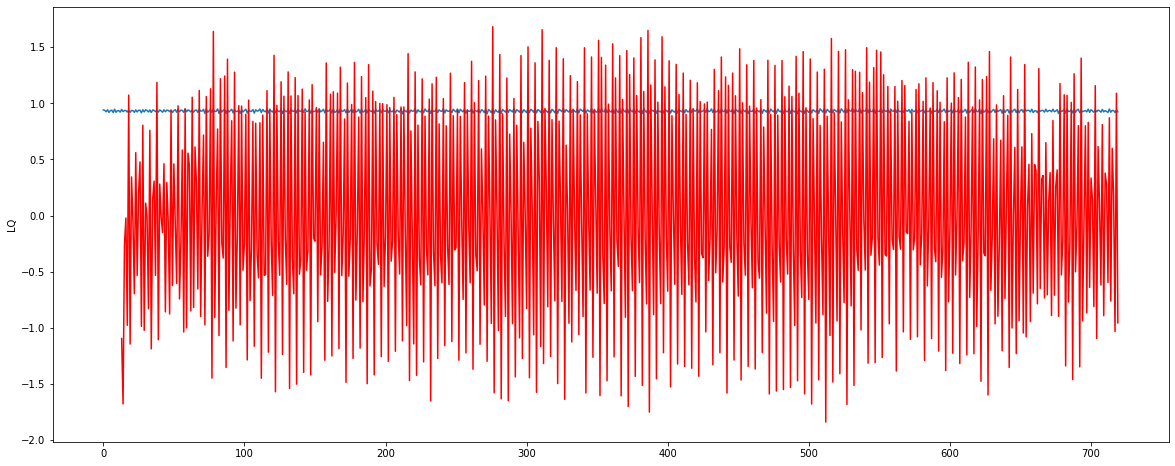

In [49]:
data['model'] = best_model.fittedvalues
plt.figure(figsize=(20,8))
data.y.plot()
data.model[13:].plot(color='r')
plt.ylabel('LQ')
#pylab.show()
print(data['model'])

In [0]:
new_data2 = new_data[['y']]
future = pd.DataFrame(index=date_list, columns= new_data.columns)
new_data2 = pd.concat([new_data2, future])
new_data2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
new_data2.y.plot()
new_data2.forecast.plot(color='r')
plt.ylabel('LQ')
pylab.show()